# 5.5 Case study: resonant freqencies of a micro-resonant transducer

This case study uses the beam element introdced in Chapter 5 to model a micro-resonant transducer. The addition over the single-element derivation is that multiple beams are used, but since the geometry is still in the X-Y plane and the beams are not rotated, the only thing to do is to
a) add more elements
b) assemble the global stiffness, and mass matrices utilizing the same techniques as in Chapter 4, e.g. Example 4.2.


In [1]:
# number of elements to be used. The book uses 10.
NE = 10  # number of elements

# number of degrees of freedom each node
ND = 2  # 2D problem, so only X and Y coordinates are used

# number of degrees of freedom per element. This is not to be changed.
DOF = 4  # u_x, u_y, u_z, θ_y, θ_z


In [2]:
# imports
import numpy as np
import scipy as sp
from source.OneD.node import Node
from source.OneD.beam.beam import BeamElement, BeamModel
np.set_printoptions(precision=2, threshold=3, suppress=False)

### Geometry and material properties

Defined as in the book and converted to SI units for consistency.

In [3]:
b = 20  # width of the beam [µm]
h = 0.5  # height of the beam [µm]
L = 100  # length of the beam [µm]
E = 169  # Young's modulus [GPa]
nu = 0.262  # Poisson's ratio
ro = 2.30  # density [g/cm³]

# transforming everything in SI units: meters, pascals, kilograms
b *= 1e-6  # width in meters
h *= 1e-6  # height in meters
L *= 1e-6  # length in meters
E *= 1e9  # Young's modulus in pascals
ro *= 1e3  # density in kg/m³

### Cross sectional properties

In [4]:
A = b * h  # cross-sectional area [m²]
Iy = b * h**3 / 12  # second moment of area around the y-axis [m^4]
Iz = h * b**3 / 12  # second moment of area around the z-axis [m^4]

### Analytical solutions for a clamped-clamped beam

In [5]:
### Analytical solutiuons
f1 = 22.3733 * np.sqrt(E * Iy / (ro * A * L ** 4)) / (2 * np.pi)  # first natural frequency [Hz]
f2 = 61.6728 * np.sqrt(E * Iy / (ro * A * L ** 4)) / (2 * np.pi)  # second natural frequency [Hz]
f3 = 120.9034 * np.sqrt(E * Iy / (ro * A * L ** 4)) / (2 * np.pi)  # third natural frequency [Hz]

### FE mesh and supports.

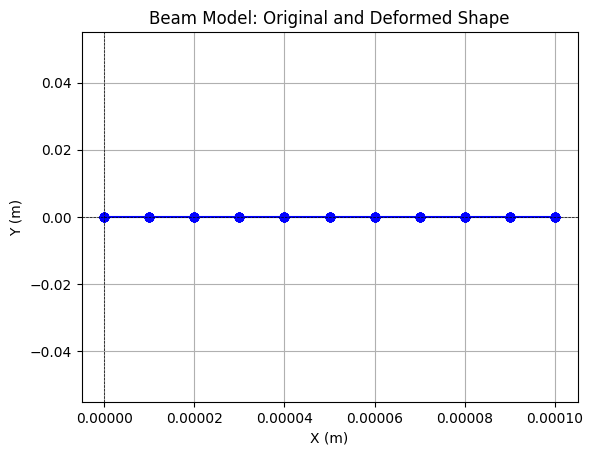

In [6]:
# Mesh
# The total length of the beam is divided into NE elements, each element has a length of L/NE.
mesh = np.linspace(0, L, NE + 1)  # mesh points along the beam

# Create nodes based on the mesh
nodes = tuple(Node(x, 0, None) for x in mesh)  # nodes in the X-Y plane, Z=0

# Create beam elements. The inertia to be used is the second moment of area around the y-axis.
elements = [(nodes[i].ID, nodes[i + 1].ID, A, Iy, E, ro) for i in range(NE)]

# supports: both ends are clamped.
supports = {0: (0, 1), NE: (0, 1)}

model = BeamModel(nodes_=nodes, elements_=elements, supports_=supports)

model.plot_model(u=None)

### Solving the model for a unit load at the middle

This is just to show that the model is working correctly.

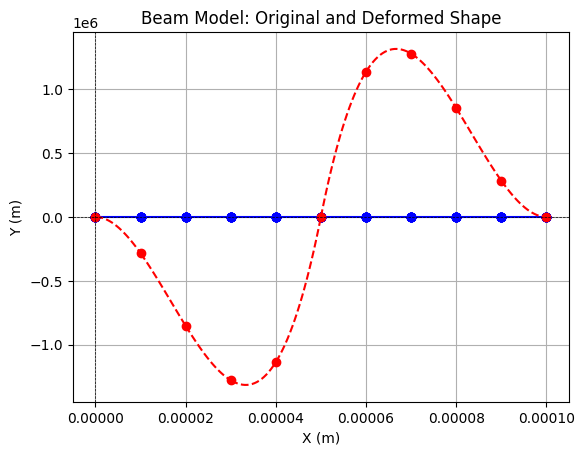

In [11]:
_F = np.zeros((len(model.nodes) * ND, 1))  # global force vector
_F[len(_F) // 2] = 1000  # 1 kNm
u, r = model.solve(_F)
model.plot_model(u)

### Solving the generalized eigenvalue problem to get the natural frequencies and mode shapes

f1 should be 440563.9866 Hz
f2 should be 1214430.3536 Hz
f3 should be 2380770.1095 Hz

1. mode shape: 510334.6469 Hz
   analytical solution: 440563.9866 Hz
   ratio to the analytical solution: 0.8632844922678381
2. mode shape: 1400325.3398 Hz
   analytical solution: 1214430.3536 Hz
   ratio to the analytical solution: 0.8672487164936741
3. mode shape: 2724131.8729 Hz
   analytical solution: 2380770.1095 Hz
   ratio to the analytical solution: 0.8739555280766896
4. mode shape: 4450329.2412 Hz
5. mode shape: 6532788.6009 Hz


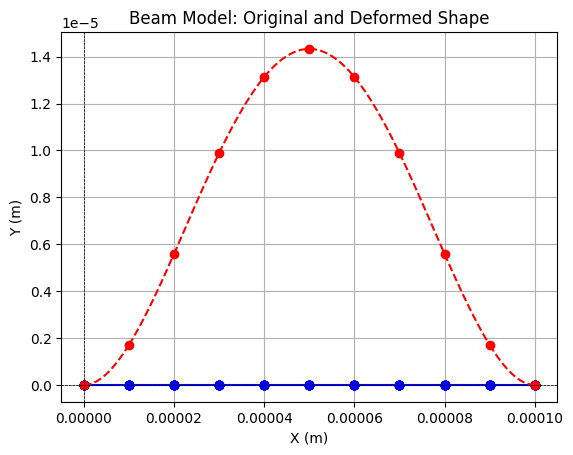

In [8]:
# Solve the generalized eigenvalue problem K * phi = lambda * M * phi
freqs, shapes = model.solve_modal()

print(f'f1 should be {f1:.4f} Hz')
print(f'f2 should be {f2:.4f} Hz')
print(f'f3 should be {f3:.4f} Hz')
fi = (f1, f2, f3)
print()
for ind, freq in enumerate(freqs[:5]):
    print(f'{ind+1}. mode shape: {freq:.4f} Hz')
    if ind < 3:
        print(f'   analytical solution: {fi[ind]:.4f} Hz')
        print(f'   ratio to the analytical solution: {fi[ind] / freq}')

model.plot_model(u=shapes[:, 0])
